# Import Libraries

In [1]:
import numpy as np 
import pandas as pd 
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

# Importing Dataset

In [2]:
df = pd.read_csv("/kaggle/input/twitter-entity-sentiment-analysis/twitter_training.csv", header=None)
df.sample(5)

,0,1,2,3
9493,12834,Xbox(Xseries),Irrelevant,It is not the first time that the EU Commissio...
42225,10044,PlayerUnknownsBattlegrounds(PUBG),Positive,NaN
43094,10195,PlayerUnknownsBattlegrounds(PUBG),Negative,Hello @ PUBGMOE @ PUBG @ PUBG _ Support I can'...
68670,3759,Cyberpunk2077,Neutral,My heart... .
26414,937,AssassinsCreed,Positive,Happy Birthday @ ShikharTheBun may you have al...


# Data Preprocessing

In [3]:
df.shape

(74682, 4)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74682 entries, 0 to 74681
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   0       74682 non-null  int64 
 1   1       74682 non-null  object
 2   2       74682 non-null  object
 3   3       73996 non-null  object
dtypes: int64(1), object(3)
memory usage: 2.3+ MB


In [5]:
df = df.drop([0], axis=1) # Irrelavent Columns are removed

In [6]:
col_name = ["Company_Name","Sentiments", "Text"] 
df.columns = col_name 

In [7]:
df.head()

,Company_Name,Sentiments,Text
0,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,Borderlands,Positive,I am coming to the borders and I will kill you...
2,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,Borderlands,Positive,im coming on borderlands and i will murder you...
4,Borderlands,Positive,im getting on borderlands 2 and i will murder ...


In [8]:
df['Text'] = df['Company_Name'] + " " + df['Text'] 

In [9]:
df.head()

,Company_Name,Sentiments,Text
0,Borderlands,Positive,Borderlands im getting on borderlands and i wi...
1,Borderlands,Positive,Borderlands I am coming to the borders and I w...
2,Borderlands,Positive,Borderlands im getting on borderlands and i wi...
3,Borderlands,Positive,Borderlands im coming on borderlands and i wil...
4,Borderlands,Positive,Borderlands im getting on borderlands 2 and i ...


In [10]:
# Checking for any other class besides 'Positive', 'Negative', 'Neutral' present or not
df_filtered = df[~df["Sentiments"].isin(['Positive', 'Negative', 'Neutral'])]
df_filtered["Sentiments"].value_counts()

Sentiments
Irrelevant    12990
Name: count, dtype: int64

In [11]:
# Remove the class 'Irrelevant' from Sentiments Column
df = df[df["Sentiments"] != 'Irrelevant']

In [12]:
# Validation DataSet
df_val = pd.read_csv("/kaggle/input/twitter-entity-sentiment-analysis/twitter_validation.csv", header=None)
df_val = df_val[df_val[2] != 'Irrelevant'][[1,2,3]]
col_name = ["Company_Name","Sentiments", "Text"] 
df_val.columns = col_name 
df_val['Text'] = df_val['Company_Name'] + " " + df_val['Text'] 
df_val.head()

,Company_Name,Sentiments,Text
1,Amazon,Neutral,Amazon BBC News - Amazon boss Jeff Bezos rejec...
2,Microsoft,Negative,Microsoft @Microsoft Why do I pay for WORD whe...
3,CS-GO,Negative,CS-GO CSGO matchmaking is so full of closet ha...
4,Google,Neutral,Google Now the President is slapping Americans...
5,FIFA,Negative,FIFA Hi @EAHelp I’ve had Madeleine McCann in m...


In [13]:
# Checking for missing value
df.isnull().sum()

Company_Name      0
Sentiments        0
Text            571
dtype: int64

In [14]:
df.dropna(how='any', axis=0, inplace = True)

In [15]:
# Checking for duplicate value
df.duplicated().sum()

2609

In [16]:
df.drop_duplicates(inplace=True)

# Data Distribution

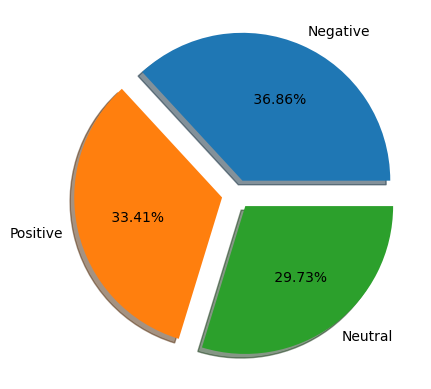

In [17]:
# Distribution of Class Labels
mylabels = df['Sentiments'].value_counts().index
myexplode = [0.1, 0.1, 0.1]

plt.pie(df['Sentiments'].value_counts(), labels = mylabels, explode = myexplode, autopct = '% .2f%%', shadow = True)
plt.show() 

# Text Preprocessing

In [18]:
import re
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

In [19]:
# Stopword
all_stopwords = stopwords.words('english')
remove_words = ["don't" ,'not', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn', "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn', "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", 'won', "won't", 'wouldn', "wouldn't"]
all_stopwords = set([i for i in all_stopwords if i  not in remove_words])
all_stopwords.add('im')
print(all_stopwords)

{'here', 'if', 'through', 'yourselves', 'those', "that'll", "should've", 'are', 'off', 're', 'between', 'all', "you're", 'a', 'into', 'itself', "you've", 'to', 'them', 's', 'theirs', 'myself', 'some', 'been', 'why', 'in', 'will', 'or', 'no', 'above', 'ourselves', 'being', 'than', 'that', 'how', 'until', 'about', 'these', 'only', 'very', 'am', 'over', 'now', 'so', 'such', 'both', 'hers', 'they', 'm', 'and', 'its', 'ain', 'has', 'our', 'own', 'below', 'while', 'their', 'few', 'were', 'any', 'my', 'did', 'nor', 'll', "you'll", 'have', 'do', 'y', 'd', 'is', 'im', 'ours', 'an', "she's", 'with', 'had', 'does', 'we', 'on', 'yourself', 'the', 'herself', 'she', 'there', 'be', 'his', 'aren', 'once', 'each', 'he', 'it', 'her', 'having', "it's", 'can', 'out', 'most', 'i', 'which', 'who', 'too', 'again', 'was', 'but', "you'd", 'for', 'then', 'himself', 'when', 'of', 'more', 'themselves', 'just', 'you', 'before', 'should', 'don', 've', 'as', 'during', 'yours', 'where', 'him', 'at', 'same', 'this', '

In [20]:
# Function to preprocess the text 
def preprocess_text(t):
    text = re.sub('[^a-zA-Z]', ' ', t)
    text = text.lower()
    text = text.split()
    ps = PorterStemmer()
    stopwords = all_stopwords
    text = [ps.stem(word) for word in text if not word in stopwords]
    text = ' '.join(text)
    return text

In [21]:
df["Text"] = df["Text"].astype(str).apply(preprocess_text)

In [22]:
df.sample(3)

,Company_Name,Sentiments,Text
55746,CallOfDuty,Negative,callofduti c stink store playstat com
44858,Verizon,Neutral,verizon new
11005,Xbox(Xseries),Negative,xbox xseri fuck big ass air condition ps


In [23]:
# Function to calculate the length of each text
def len_calculation(str):
        s = str.split()
        return len(s)

In [24]:
df["Text_len"] = df["Text"].astype(str).apply(len_calculation)

In [25]:
df = df[["Company_Name", "Text", "Text_len", "Sentiments"]]
df.head()

,Company_Name,Text,Text_len,Sentiments
0,Borderlands,borderland get borderland murder,4,Positive
1,Borderlands,borderland come border kill,4,Positive
2,Borderlands,borderland get borderland kill,4,Positive
3,Borderlands,borderland come borderland murder,4,Positive
4,Borderlands,borderland get borderland murder,4,Positive


In [26]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer()

In [27]:
X = tfidf.fit_transform(df["Text"])
y = df['Sentiments'].values

In [28]:
# Saving the tfidf Model
with open ('model_pickel_tfidf', 'wb') as fe:
    pickle.dump(tfidf, fe)

In [29]:
# LabelEncoding the target values
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y = le.fit_transform(y)

# Check for the mapping of each target class
print(dict(zip(le.classes_, range(len(le.classes_)))))

{'Negative': 0, 'Neutral': 1, 'Positive': 2}


# EDA

In [30]:
from wordcloud import WordCloud
from collections import Counter

wc = WordCloud(width=500, height=500, min_font_size=10, background_color='white')

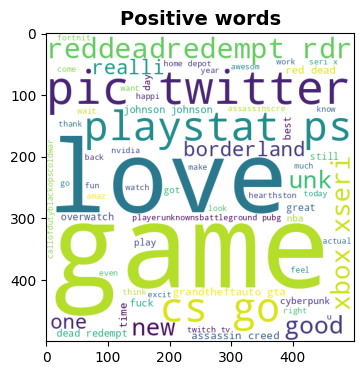

In [31]:
# WordCloud for Positive Sentiments
pos_wc = wc.generate(df[df['Sentiments'] == 'Positive']['Text'].str.cat(sep=" "))
plt.figure(figsize=(4,4), facecolor = None)
plt.imshow(pos_wc)
# plt.axis("off")
plt.title("Positive words", fontweight='bold', fontsize = 14)
plt.show()

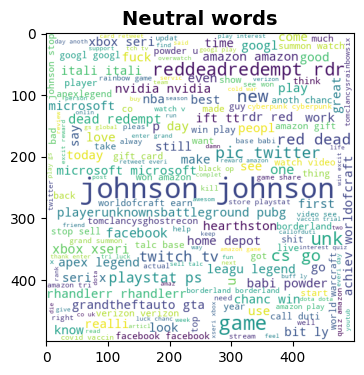

In [32]:
# WordCloud for Neutral Sentiments
pos_wc = wc.generate(df[df['Sentiments'] == 'Neutral']['Text'].str.cat(sep=" "))
plt.figure(figsize=(4,4))
plt.imshow(pos_wc)
# plt.axis("off")
plt.title("Neutral words", fontweight='bold', fontsize = 14)
plt.show()

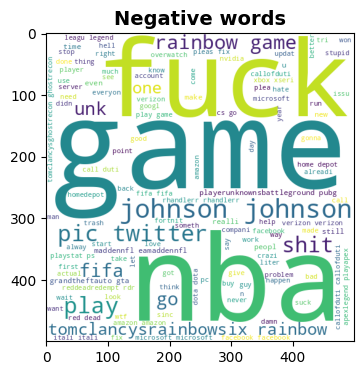

In [33]:
# WordCloud for Negative Sentiments
pos_wc = wc.generate(df[df['Sentiments'] == 'Negative']['Text'].str.cat(sep=" "))
plt.figure(figsize=(4,4))
plt.imshow(pos_wc)
# plt.axis("off")
plt.title("Negative words", fontweight='bold', fontsize = 14)
plt.show()

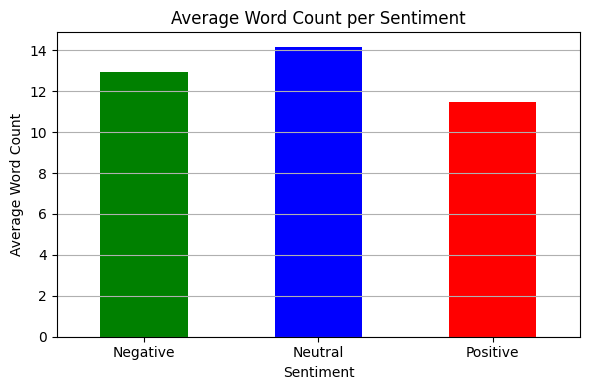

In [34]:
# Avg. word count per sentiments
avg_word_count = df.groupby('Sentiments')['Text_len'].mean()

# Plotting
plt.figure(figsize=(6,4))
avg_word_count.plot(kind='bar', color=['green', 'blue', 'red'])
plt.title('Average Word Count per Sentiment')
plt.xlabel('Sentiment')
plt.ylabel('Average Word Count')
plt.xticks(rotation=0)
plt.grid(axis='y')

plt.tight_layout()
plt.show()

In [35]:
# Function to count top 30 most frequent words

def top_30_words(sentiment):
    msg = df[df['Sentiments'] == sentiment]['Text'].tolist()
    corpus = []
    for m in msg:
        for word in m.split():
            corpus.append(word)
            
    common_30_words =  pd.DataFrame(Counter(corpus).most_common(30))
    
    plt.figure(figsize=(6,4))
    sns.barplot(x= common_30_words[0], y= common_30_words[1], palette="magma")
    plt.xticks(rotation = 'vertical')
    plt.xlabel(f"30 most frequenct words in {sentiment} Sentiments", fontweight='bold')
    plt.ylabel("Count", fontweight='bold')
    plt.legend().remove()
    plt.show()

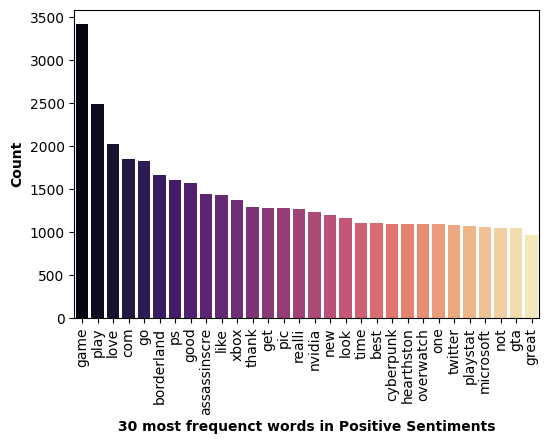

In [36]:
top_30_words('Positive')

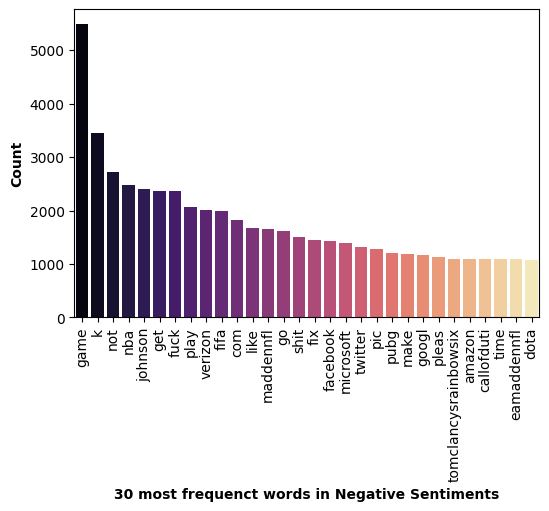

In [37]:
top_30_words('Negative')

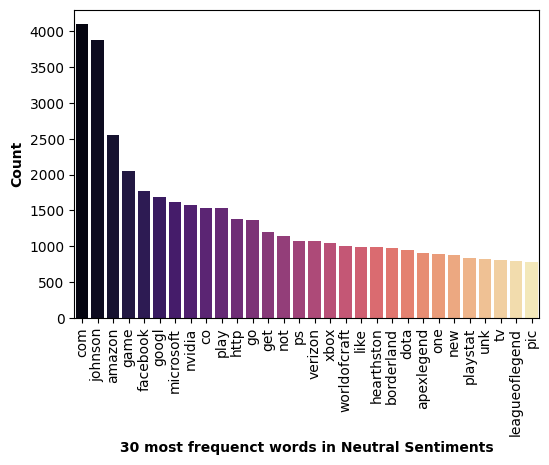

In [38]:
top_30_words('Neutral')

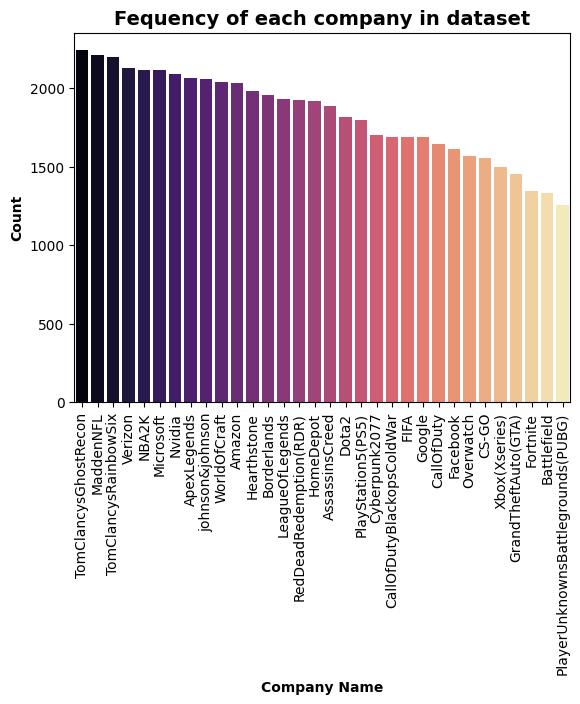

In [39]:
# Company Name vs Count
comp_count = df["Company_Name"].value_counts()

sns.barplot(x= comp_count.index, y= comp_count.values, palette="magma")
plt.xticks(rotation = 'vertical')
plt.title("Fequency of each company in dataset", fontweight='bold', fontsize = 14)
plt.xlabel("Company Name", fontweight='bold')
plt.ylabel("Count", fontweight='bold')
plt.legend().remove()
plt.show()

# Spliting the dataset into Train and Test Set

In [40]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0, stratify=y)

# Model Building

## Machine Learning Model : Naive Bayes

In [41]:
from sklearn.naive_bayes import MultinomialNB

classifier1 = MultinomialNB()
classifier1.fit(X_train, y_train)

MultinomialNB()

In [42]:
with open ('model_pickel_naive_bayes', 'wb') as f:
    pickle.dump(classifier1, f)

In [43]:
y_pred = classifier1.predict(X_test)

print(f"Accuracy: {accuracy_score(y_test, y_pred) * 100 :.2f}%")
print(f"Recall: {recall_score(y_test, y_pred, average = 'macro') * 100 :.2f}%")
print(f"Precision: {precision_score(y_test, y_pred, average = 'macro') * 100:.2f}%")
print(f"F1 score: {f1_score(y_test, y_pred, average = 'macro') * 100:.2f}%")

Accuracy: 77.72%
Recall: 76.79%
Precision: 79.03%
F1 score: 77.08%


In [119]:
# Validation Dataset Accuracy
y_test = le.transform(df_val['Sentiments'])

tfidf_new = tfidf.transform(df_val['Text'].astype(str).apply(preprocess_text).values)
y_pred = classifier1.predict(tfidf_new)

print(f"Accuracy: {accuracy_score(y_test, y_pred) * 100 :.2f}%")

Accuracy: 81.40%


## Machine Learning Model : Random Forest

In [44]:
from sklearn.ensemble import RandomForestClassifier

classifier2 = RandomForestClassifier(n_estimators=10)
classifier2.fit(X_train, y_train)

RandomForestClassifier(n_estimators=10)

In [45]:
y_pred = classifier2.predict(X_test)

print(f"Accuracy: {accuracy_score(y_test, y_pred) * 100 :.2f}%")
print(f"Recall: {recall_score(y_test, y_pred, average = 'macro') * 100 :.2f}%")
print(f"Precision: {precision_score(y_test, y_pred, average = 'macro') * 100:.2f}%")
print(f"F1 score: {f1_score(y_test, y_pred, average = 'macro') * 100:.2f}%")

Accuracy: 91.75%
Recall: 91.59%
Precision: 91.90%
F1 score: 91.72%


In [117]:
# Validation Dataset Accuracy
y_test = le.transform(df_val['Sentiments'])

tfidf_new = tfidf.transform(df_val['Text'].astype(str).apply(preprocess_text).values)
y_pred = classifier2.predict(tfidf_new)

print(f"Accuracy: {accuracy_score(y_test, y_pred) * 100 :.2f}%")

Accuracy: 95.17%


## Machine Learning Model : XGBoost

In [46]:
from xgboost import XGBClassifier

classifier3 = XGBClassifier(max_depth = 6, n_estimators=10)
classifier3.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=10, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [47]:
y_pred = classifier3.predict(X_test)

print(f"Accuracy: {accuracy_score(y_test, y_pred) * 100 :.2f}%")
print(f"Recall: {recall_score(y_test, y_pred, average = 'macro') * 100 :.2f}%")
print(f"Precision: {precision_score(y_test, y_pred, average = 'macro') * 100:.2f}%")
print(f"F1 score: {f1_score(y_test, y_pred, average = 'macro') * 100:.2f}%")

Accuracy: 61.86%
Recall: 60.58%
Precision: 64.55%
F1 score: 60.67%


In [118]:
# Validation Dataset Accuracy
y_test = le.transform(df_val['Sentiments'])

tfidf_new = tfidf.transform(df_val['Text'].astype(str).apply(preprocess_text).values)
y_pred = classifier3.predict(tfidf_new)

print(f"Accuracy: {accuracy_score(y_test, y_pred) * 100 :.2f}%")

Accuracy: 64.13%


# Deep Learning Model : LSTM

In [63]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import pad_sequences,  to_categorical

In [64]:
y_encoded = to_categorical(y, num_classes=3)  # to_categorical is used to convert class labels into a one-hot encoded format
y_encoded 

array([[0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       ...,
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.]])

In [65]:
tokenizer = Tokenizer(oov_token='OOV') # Out Of Vocab token - this will replace any unknown words with a token of our choosing.
tokenizer.fit_on_texts(df['Text']) 

In [66]:
Voc_len = len(tokenizer.word_index) # No of unique words in doc
Voc_len 

19281

In [67]:
# len(tokenizer.word_index) # To check the Vocabulary(No of unique words in doc)
# tokenizer.word_counts # Check the frequency of each word
# tokenizer.document_count # To check how many rows in document

In [68]:
sequences = tokenizer.texts_to_sequences(df['Text']) # To convert the text into sequence of numbers
sequences = pad_sequences(sequences, padding = 'post')
sequences

array([[  20,    8,   20, ...,    0,    0,    0],
       [  20,   89, 1729, ...,    0,    0,    0],
       [  20,    8,   20, ...,    0,    0,    0],
       ...,
       [  14,  856,  420, ...,    0,    0,    0],
       [  14,  856,  420, ...,    0,    0,    0],
       [  14,   11,  420, ...,    0,    0,    0]], dtype=int32)

In [69]:
X_train, X_test, y_train, y_test = train_test_split(sequences, y_encoded, test_size = 0.2, random_state = 0, stratify=y_encoded)

In [70]:
y_train.shape

(46809, 3)

In [71]:
word_len = len(sequences[0])
word_len # Word count for each sentance

164

In [74]:
# model initialization
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(Voc_len, output_dim= 32),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
])

# compile model
model.build(input_shape=(None, word_len))
model.compile(
    loss="categorical_crossentropy",
    optimizer='adam',
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

# model summary
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 164, 32)        │       616,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 128)            │        49,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 24)             │         3,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │            75 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 669,827 (2.56 MB)

 Trainable params: 669,827 (2.56 MB)

 Non-trainable params: 0 (0.00 B)

In [75]:
history = model.fit(X_train, y_train,
                    batch_size=64,
                    epochs=5,
                    verbose=1, 
                    shuffle=True, 
                    validation_data=(X_test, y_test))

Epoch 1/5
732/732 ━━━━━━━━━━━━━━━━━━━━ 15s 16ms/step - accuracy: 0.6059 - loss: 0.8333 - precision: 0.7051 - recall: 0.4087 - val_accuracy: 0.7314 - val_loss: 0.6288 - val_precision: 0.7791 - val_recall: 0.6710
Epoch 2/5
732/732 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step - accuracy: 0.8516 - loss: 0.3879 - precision: 0.8791 - recall: 0.8230 - val_accuracy: 0.8668 - val_loss: 0.3524 - val_precision: 0.8870 - val_recall: 0.8488
Epoch 3/5
732/732 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step - accuracy: 0.9088 - loss: 0.2465 - precision: 0.9250 - recall: 0.8932 - val_accuracy: 0.8793 - val_loss: 0.3262 - val_precision: 0.8961 - val_recall: 0.8641
Epoch 4/5
732/732 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step - accuracy: 0.9278 - loss: 0.1918 - precision: 0.9428 - recall: 0.9160 - val_accuracy: 0.8781 - val_loss: 0.3309 - val_precision: 0.8916 - val_recall: 0.8653
Epoch 5/5
732/732 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step - accuracy: 0.9359 - loss: 0.1643 - precision: 0.9478 - recall: 0.9271 - val_accuracy: 0.8863 - val_los

In [76]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 164, 32)        │       616,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 128)            │        49,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 24)             │         3,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │            75 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,009,483 (7.67 MB)

 Trainable params: 669,827 (2.56 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,339,656 (5.11 MB)

In [80]:
 # Printing model score on test data
loss, accuracy, recall, precision = model.evaluate(X_test, y_test, verbose=0)

f1_score = (2*recall*precision)/(recall+precision)

print(f"Accuracy: {accuracy * 100 :.2f}%")
print(f"Recall: {recall* 100 :.2f}%")
print(f"Precision: {precision * 100:.2f}%")
print(f"F1 score: {f1_score * 100:.2f}%")

Accuracy: 88.63%
Recall: 89.89%
Precision: 87.73%
F1 score: 88.80%


In [84]:
# Predict the sentiment
def pred_sentiment(seq): 
    
    df_demo = seq.apply(preprocess_text)
    seq_pred = tokenizer.texts_to_sequences(df_demo)
    seq_pred = pad_sequences(seq_pred, maxlen=word_len, padding='post')  # Assuming word_len is defined
    
    pred = model.predict(seq_pred)
  
    y_pred = []

    for j in pred:
        i = np.argmax(j)
        if i == 0:
            # print("Negative")
            y_pred.append("Negative")
        elif i == 1:
            # print("Neutral")
            y_pred.append("Neutral")
        else:
            # print("Positive")
            y_pred.append("Positive")
            
    return y_pred

In [89]:
# Calculating the accuracy for validation dataset
y_pred = pred_sentiment(df_val['Text'])

correct_predictions = 0
total_predictions = len(y_pred)

for pred, true_label in zip(y_pred, df_val['Sentiments']):
    if pred == true_label:
        correct_predictions += 1

accuracy = correct_predictions / total_predictions
print(f"Accuracy: {accuracy * 100 :.2f}%")

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Accuracy: 94.32%


In [90]:
def plot_model_performance(hist_obj, width = 10, height = 4):
    plt.figure(figsize = (width, height))
    plt.subplot(1, 2, 1)
    plt.plot(np.array(hist_obj.epoch)+1, hist_obj.history["accuracy"], label = "train_acc")
    plt.plot(np.array(hist_obj.epoch)+1, hist_obj.history["val_accuracy"], label = "val_acc")
    plt.title("Model Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.grid(True)
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(np.array(hist_obj.epoch)+1, hist_obj.history["loss"], label = "train_loss")
    plt.plot(np.array(hist_obj.epoch)+1, hist_obj.history["val_loss"], label = "val_loss")
    plt.title("Model Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid(True)
    plt.legend()

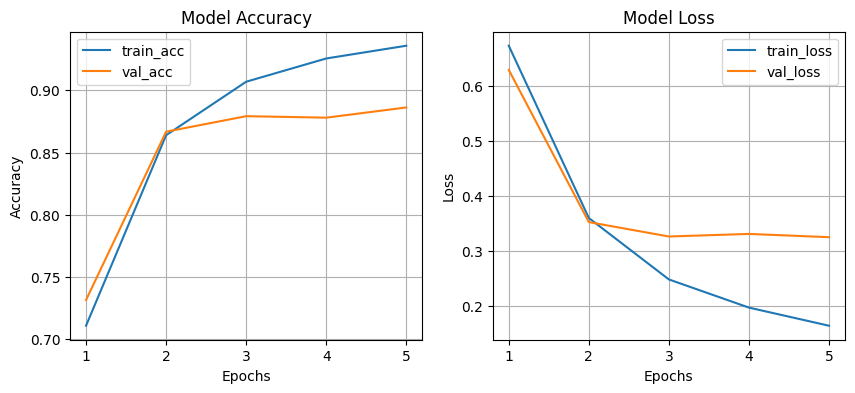

In [91]:
plot_model_performance(history)

In [92]:
model.save('LSTM_model.h5') # To save the LSTM MOdel

## Pretrain Model : AFFIN 

In [94]:
!pip install afinn

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.6/52.6 kB 3.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for afinn: filename=afinn-0.1-py3-none-any.whl size=53429 sha256=6c9a1358354db2acb44f593a43c000d2a025bb6092b393ad79500e1a7b05a7e6
  Stored in directory: /root/.cache/pip/wheels/b0/05/90/43f79196199a138fb486902fceca30a2d1b5228e6d2db8eb90
Successfully built afinn


In [95]:
from afinn import Afinn
afn = Afinn()

In [98]:
sentences = df_val.head(5)['Text'].apply(preprocess_text)
scores = [afn.score(article) for article in sentences]
sentiment = ['Positive' if score > 0 else 'Negative' if score < 0 else 'Neutral' for score in scores]

# dataframe creation
df1 = pd.DataFrame()
df1['topic'] = sentences
df1['scores'] = scores
df1['predicted_sentiments'] = sentiment
df1['Actual_Sentiments'] = df_val['Sentiments']
df1['Predicted_By_LSTM'] = pred_sentiment(sentences)
df1

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


,topic,scores,predicted_sentiments,Actual_Sentiments,Predicted_By_LSTM
1,amazon bbc news amazon boss jeff bezo reject c...,1.0,Positive,Neutral,Neutral
2,microsoft microsoft pay word function poorli s...,-1.0,Negative,Negative,Negative
3,cs go csgo matchmak full closet hack truli aw ...,0.0,Neutral,Negative,Negative
4,googl presid slap american face realli commit ...,1.0,Positive,Neutral,Neutral
5,fifa hi eahelp madelein mccann cellar past yea...,2.0,Positive,Negative,Negative


In [100]:
# Predict the sentiment
def pred_sentiment(seq): 
    
    df_demo = seq.apply(preprocess_text)
    seq_pred = tokenizer.texts_to_sequences(df_demo)
    seq_pred = pad_sequences(seq_pred, maxlen=word_len, padding='post')  # Assuming word_len is defined
    
    pred = model.predict(seq_pred)
  
    y_pred = []

    for j in pred:
        i = np.argmax(j)
        if i < 0:
            # print("Negative")
            y_pred.append("Negative")
        elif i == 0:
            # print("Neutral")
            y_pred.append("Neutral")
        else:
            # print("Positive")
            y_pred.append("Positive")
            
    return y_pred

In [101]:
# Calculating the accuracy for validation dataset
y_pred = pred_sentiment(df_val['Text'])

correct_predictions = 0
total_predictions = len(y_pred)

for pred, true_label in zip(y_pred, df_val['Sentiments']):
    if pred == true_label:
        correct_predictions += 1

accuracy = correct_predictions / total_predictions
print(f"Accuracy: {accuracy * 100 :.2f}%")

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Accuracy: 33.94%
